<a href="https://colab.research.google.com/github/ariahosseini/DeepML/blob/main/001_TensorFlow_Proj_One_FFNN_RandomSamples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

### Libs

In [1]:
# utils
import os, sys, itertools, warnings, platform, random
import numpy as np
import pandas as pd
import scipy.ndimage as ndimage
from random import randint
# sklearn
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.utils import plot_model
from tensorflow.config import list_physical_devices
from tensorflow.keras.models import (Sequential,
                                     load_model)
from tensorflow.keras.layers import (Input,
                                     Conv2D,
                                     MaxPooling2D,
                                     Flatten,
                                     Dense,
                                     Activation,
                                     AveragePooling2D,
                                     Dropout,
                                     Rescaling,
                                     Reshape,
                                     BatchNormalization,
                                     ZeroPadding2D,
                                     UpSampling2D,
                                     add)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import (CategoricalCrossentropy,
                                      SparseCategoricalCrossentropy)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.datasets import mnist
# vis
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns

In [2]:
print("tensorflow version: ", tf.__version__)

tensorflow version:  2.17.0


### Settings

In [3]:
# setup gpu
if tf.config.list_physical_devices('GPU'):
    physical_devices = tf.config.list_physical_devices("GPU")
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU memory growth set for device:", physical_devices[0])
    except Exception as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

GPU memory growth set for device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
# tensorflow verbos
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [5]:
warnings.filterwarnings("ignore")

## Func

In [6]:
def plot_training_results(history, model, x_test, y_test, n_samples=15):
    """
    Plot the training/validation loss, accuracy, confusion matrix, and
    true vs. predicted labels for a small sample.

    Layout:
    - First row: one plot (Loss)
    - Second row: one plot (Accuracy)
    - Third row: two plots (Confusion Matrix, True vs Predicted Labels)

    Parameters:
    - history: The history object returned by model.fit().
    - model: The trained Keras model.
    - x_test: Test data for evaluation.
    - y_test: True labels for test data.
    - n_samples: Number of samples to show in the true vs. predicted labels plot.
    """

    fig = plt.figure(figsize=(10, 12))
    grid = plt.GridSpec(3, 2, hspace=0.4, wspace=0.4)

    # plot training & validation loss
    ax1 = fig.add_subplot(grid[0, :])
    ax1.plot(history.history['loss'], '-o', label='Training loss')
    if 'val_loss' in history.history:
        ax1.plot(history.history['val_loss'], '-o', label='Validation loss')
    ax1.set_title('Model Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='upper right')

    # plot training & validation accuracy
    ax2 = fig.add_subplot(grid[1, :])
    ax2.plot(history.history['accuracy'], '-o', label='Training accuracy')
    if 'val_accuracy' in history.history:
        ax2.plot(history.history['val_accuracy'], '-o', label='Validation accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='lower right')

    # confusion Matrix
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    ax3 = fig.add_subplot(grid[2, 0])
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax3)
    ax3.set_title('Confusion Matrix')
    ax3.set_ylabel('True Label')
    ax3.set_xlabel('Predicted Label')

    # true vs Predicted Labels
    y_test_sample = y_test[:n_samples]
    y_pred_sample = y_pred_classes[:n_samples]

    ax4 = fig.add_subplot(grid[2, 1])
    ax4.plot(y_test_sample, linestyle="None", color='steelblue', marker='o', label='True Label')
    ax4.plot(y_pred_sample, linestyle="None", color='lightcoral', marker='x', label='Predicted Label')
    ax4.set_title('True vs Predicted Labels (Sample)')
    ax4.set_ylabel('Label')
    ax4.set_xlabel('Sample Index')
    ax4.legend(loc='best')

    plt.tight_layout()
    plt.show()

In [7]:
def plot_loss(history):
    """Plots the training loss curve."""
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], '-o', label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], '-o', label='Validation Loss')
    plt.title('Autoencoder Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [8]:
def plot_reconstructions(model, x_test, n_images=10):
    """Plots original vs. reconstructed images to visualize the autoencoder's performance."""
    decoded_imgs = model.predict(x_test)

    plt.figure(figsize=(20, 4))
    for i in range(n_images):

        ax = plt.subplot(2, n_images, i + 1)
        plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        ax = plt.subplot(2, n_images, i + 1 + n_images)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

In [9]:
def plot_latent_space(encoder, x_test, y_test):
    """Visualizes the latent space if it is 2D or can be reduced to 2D."""
    latent_representations = encoder.predict(x_test)
    latent_reshaped = latent_representations.reshape(len(latent_representations), -1)

    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_reshaped)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=y_test, palette="Set2", legend='full')
    plt.title('2D Latent Space Representation')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.show()

In [10]:
def plot_reconstruction_error(model, x_test, n_samples=100):
    """Plots the reconstruction error (MSE) for individual test samples."""
    decoded_imgs = model.predict(x_test)
    mse = np.mean(np.square(x_test - decoded_imgs), axis=(1, 2, 3))

    plt.figure(figsize=(8, 4))
    plt.hist(mse, bins=n_samples, color='steelblue')
    plt.title('Reconstruction Error (MSE) per Sample')
    plt.xlabel('MSE')
    plt.ylabel('Number of Samples')
    plt.show()

## Sequential FFNN Model

### Dataset

In [ ]:
# generate a train set
train_labels = []
train_samples = []
for i in range(50): # outliers
  random_younger = randint(13, 64)
  train_samples.append(random_younger)
  train_labels.append(1)
  random_older = randint(65, 100)
  train_samples.append(random_older)
  train_labels.append(0)
for i in range(1000): # inliners
  random_younger = randint(13, 64)
  train_samples.append(random_younger)
  train_labels.append(0)
  random_older = randint(65, 100)
  train_samples.append(random_older)
  train_labels.append(1)
# train set
train_labels = np.asarray(train_labels)
train_samples = np.asarray(train_samples)
train_labels, train_samples = shuffle(train_labels, train_samples)

In [ ]:
# generate a test case
test_labels = []
test_samples = []
for i in range(10): # outliers
  random_younger = randint(13, 64)
  test_samples.append(random_younger)
  test_labels.append(1)
  random_older = randint(65, 100)
  test_samples.append(random_older)
  test_labels.append(0)
for i in range(200): # inliners
  random_younger = randint(13, 64)
  test_samples.append(random_younger)
  test_labels.append(0)
  random_older = randint(65, 100)
  test_samples.append(random_older)
  test_labels.append(1)
# test set
test_labels = np.asarray(test_labels)
test_samples = np.asarray(test_samples)
test_labels, test_samples = shuffle(test_labels, test_samples)

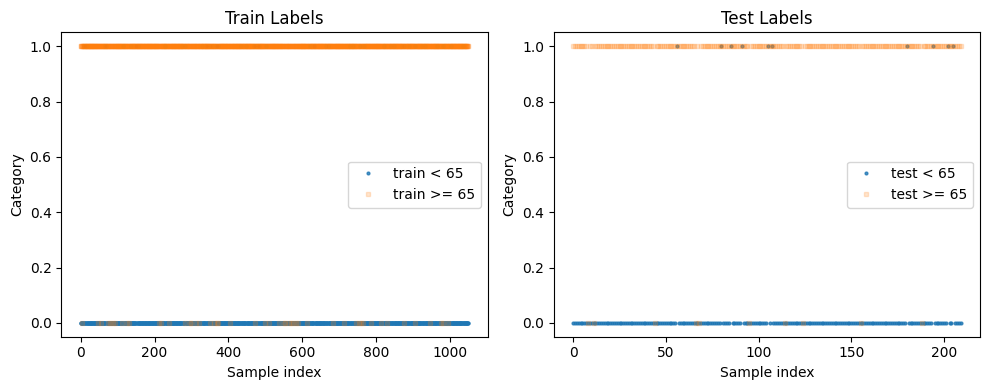

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(train_labels[train_samples < 65], 'o', markersize=2, alpha=0.8, label="train < 65")
axs[0].plot(train_labels[train_samples >= 65], 's', markersize=3, alpha=0.2, label="train >= 65")
axs[0].set_xlabel("Sample index")
axs[0].set_ylabel("Category")
axs[0].set_title("Train Labels")
axs[0].legend()

axs[1].plot(test_labels[test_samples < 65], 'o', markersize=2, alpha=0.8, label="test < 65")
axs[1].plot(test_labels[test_samples >= 65], 's', markersize=3, alpha=0.2, label="test >= 65")
axs[1].set_xlabel("Sample index")
axs[1].set_ylabel("Category")
axs[1].set_title("Test Labels")
axs[1].legend()

plt.tight_layout()
plt.show()

### Engineer Data

In [ ]:
# scale data
scaler = MinMaxScaler(feature_range=(0,1))
train_set = scaler.fit_transform(train_samples.reshape(-1,1))
test_set = scaler.transform(test_samples.reshape(-1,1))

### Develop Model

In [ ]:
# sequential model
model = Sequential(
    [Dense(units=16, input_shape=(1,), activation="relu"),
     Dense(units=32, activation="relu"),
     Dense(units=2, activation="softmax")]
    )
model.summary()
model.compile(optimizer=Adam(learning_rate=1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(x=train_set, y=train_labels, validation_split=0.1,
                    batch_size=10, epochs=100, shuffle=True, verbose=0)
pred = model.predict(x=test_set, batch_size=100, verbose=2)
loss, accuracy = model.evaluate(x=test_set, y=test_labels, batch_size=32, verbose=2)
print(f"\nTest accuracy: {accuracy:.4f}")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 16)                  │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 642 (2.51 KB)

 Trainable params: 642 (2.51 KB)

 Non-trainable params: 0 (0.00 B)

5/5 - 0s - 16ms/step
14/14 - 0s - 10ms/step - accuracy: 0.9500 - loss: 0.2442

Test accuracy: 0.9500


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


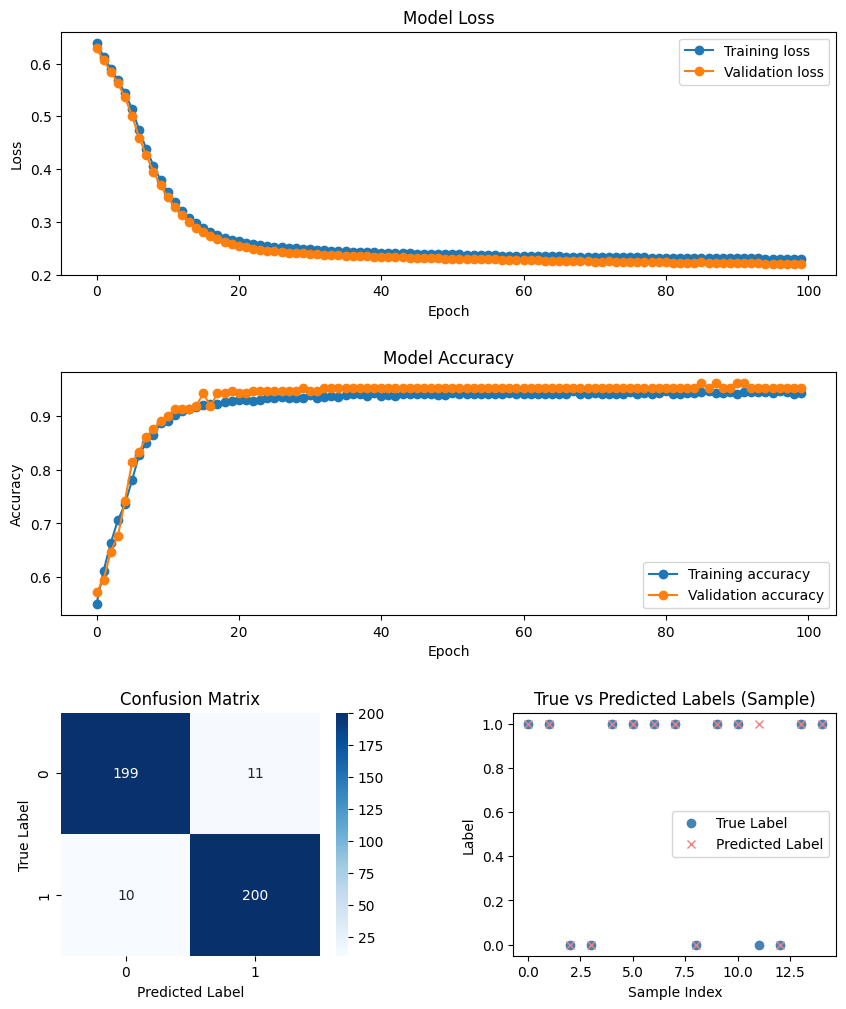

In [ ]:
plot_training_results(history, model, test_set, test_labels)

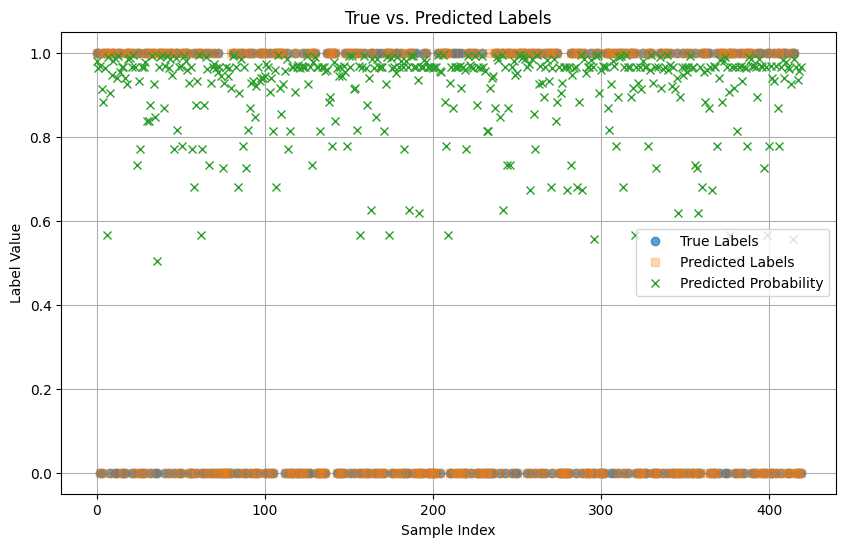

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test_labels, label='True Labels', marker='o', linestyle='None', alpha=0.7)
plt.plot(np.argmax(pred, axis=-1), label='Predicted Labels', marker='s', linestyle='None', alpha=0.3)
plt.plot(pred.max(axis=1), label='Predicted Probability', marker='x', linestyle='None')
plt.xlabel('Sample Index')
plt.ylabel('Label Value')
plt.title('True vs. Predicted Labels')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
if os.path.isfile("model.h5") is False:
  model.save("model.h5")

# Autoencoder - Denoising Pics

### Dataset

In [11]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32")/255.
x_test = x_test.astype("float32")/255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
def add_noise_with_blur(images, noise_factor=0.5, blur_sigma=1.0):
    """Adds Gaussian noise and blur to images.
    Args:
    images: The input images as a NumPy array.
    noise_factor: The intensity of the Gaussian noise.
    blur_sigma: The standard deviation of the Gaussian blur.
    Returns:
    The noisy and blurred images as a NumPy array.
    """

    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    blurred_images = ndimage.gaussian_filter(noisy_images, sigma=blur_sigma)

    blurred_images = np.clip(blurred_images, 0., 1.)

    return blurred_images

x_train_noisy = add_noise_with_blur(x_train)
x_test_noisy = add_noise_with_blur(x_test)

### Develop Model

In [13]:
def build_encoder(input_shape, encoding_dim): # encoder
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, kernel_size=3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = layers.Conv2D(128, kernel_size=3, activation="relu", padding="same")(x)
    encoded = layers.MaxPooling2D(pool_size=2, padding="same")(x)

    return models.Model(inputs, encoded, name="Encoder")

def build_decoder(encoded_shape): # decoder
    encoded_inputs = layers.Input(shape=encoded_shape)

    x = layers.Conv2D(128, kernel_size=3, activation="relu", padding="same")(encoded_inputs)
    x = layers.UpSampling2D(size=2)(x)
    x = layers.Conv2D(64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.UpSampling2D(size=2)(x)
    x = layers.Conv2D(32, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.UpSampling2D(size=2)(x)
    x = layers.Conv2D(1, kernel_size=3, activation="sigmoid", padding="same")(x)
    decoded = layers.Cropping2D(((2, 2), (2, 2)))(x)

    return models.Model(encoded_inputs, decoded, name="Decoder")


def build_autoencoder(input_shape, encoding_dim): # build autoencoder

    encoder = build_encoder(input_shape, encoding_dim)
    decoder = build_decoder(encoder.output_shape[1:])

    autoencoder_input = layers.Input(shape=input_shape)
    encoded_output = encoder(autoencoder_input)
    decoded_output = decoder(encoded_output)

    autoencoder = models.Model(autoencoder_input, decoded_output, name="Autoencoder")
    autoencoder.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    return autoencoder

encoding_dim = 32
autoencoder = build_autoencoder(input_shape=x_train[0].shape,
                                encoding_dim=encoding_dim)
autoencoder.summary()

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder (Functional)                 │ (None, 4, 4, 128)           │          92,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder (Functional)                 │ (None, 28, 28, 1)           │         240,129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 332,801 (1.27 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

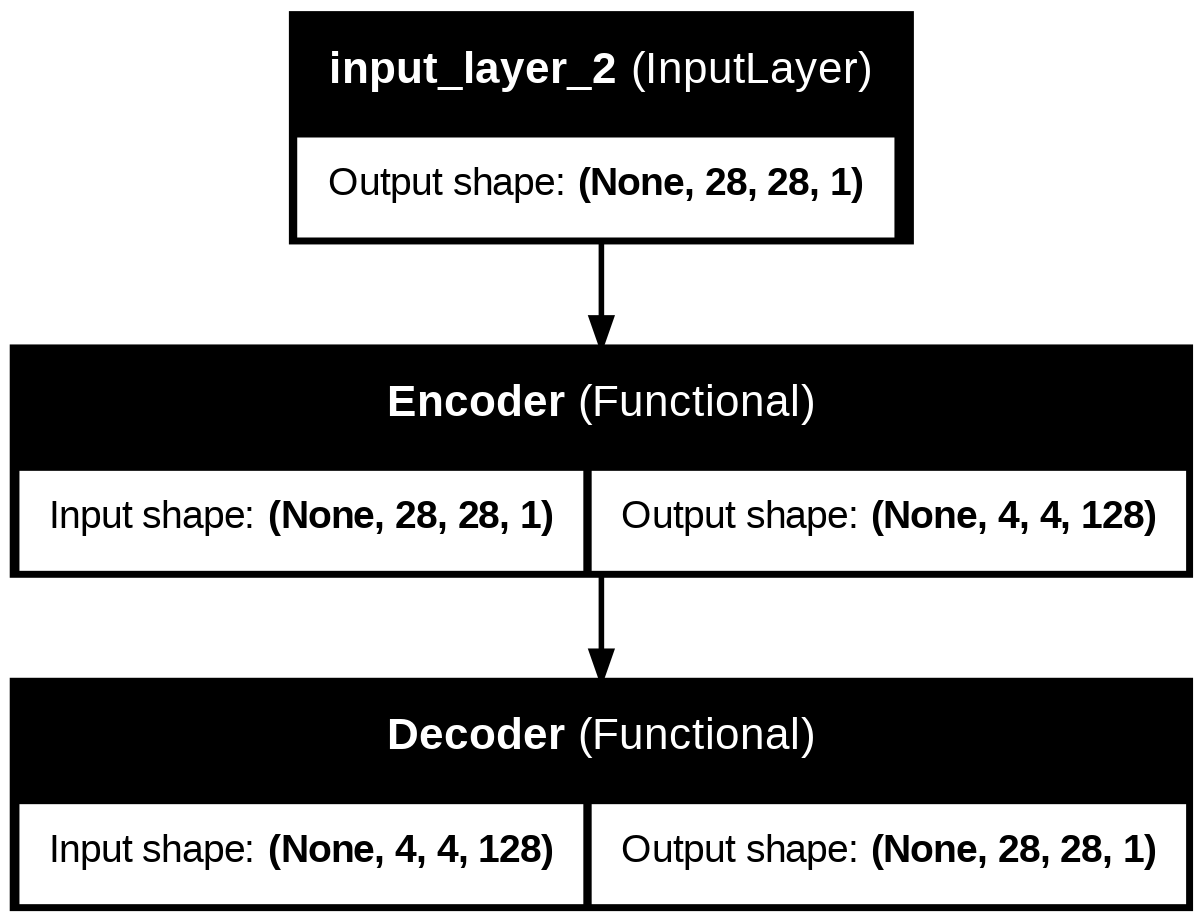

In [14]:
plot_model(autoencoder, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [15]:
history= autoencoder.fit(
    x_train_noisy,
    x_train,
    epochs=10,
    batch_size=64,
    shuffle=True,
    validation_split=0.2
    )

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.7921 - loss: 0.2593 - val_accuracy: 0.7999 - val_loss: 0.1855
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.7976 - loss: 0.1843 - val_accuracy: 0.8019 - val_loss: 0.1765
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7987 - loss: 0.1767 - val_accuracy: 0.8006 - val_loss: 0.1718
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7986 - loss: 0.1728 - val_accuracy: 0.8025 - val_loss: 0.1696
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7995 - loss: 0.1696 - val_accuracy: 0.8039 - val_loss: 0.1724
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8001 - loss: 0.1676 - val_accuracy: 0.8008 - val_loss: 0.1664
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8009 - loss: 0.1648 - val_accuracy: 0.8012 - val_loss: 0.1656
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8007 - loss: 0.1630 - val_accuracy:

In [16]:
loss, accuracy = autoencoder.evaluate(x_test_noisy, x_test, batch_size=64)
print(f"\nTest accuracy: {accuracy:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8095 - loss: 0.1615

Test accuracy: 0.8016


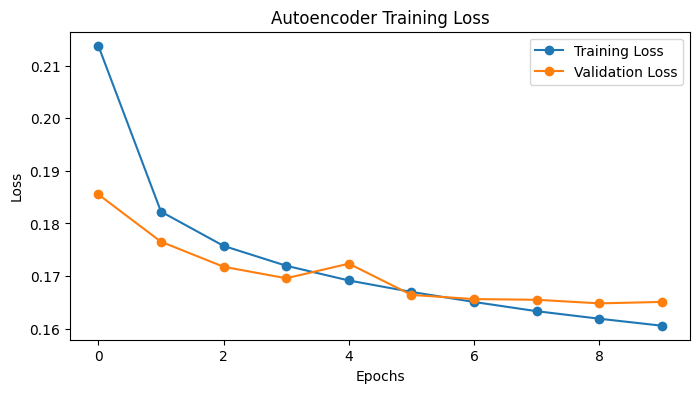

In [17]:
plot_loss(history)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


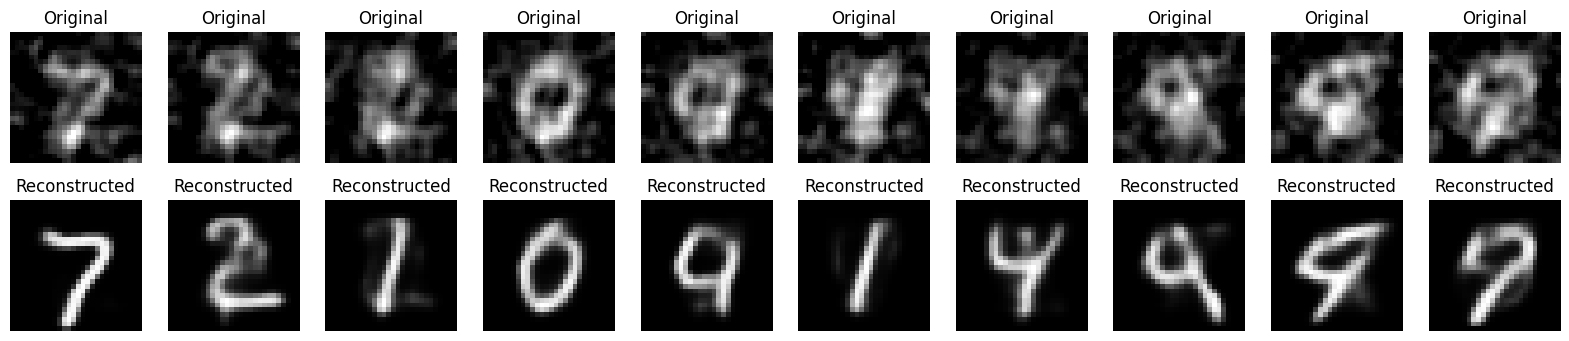

In [18]:
plot_reconstructions(autoencoder, x_test_noisy, n_images=10)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


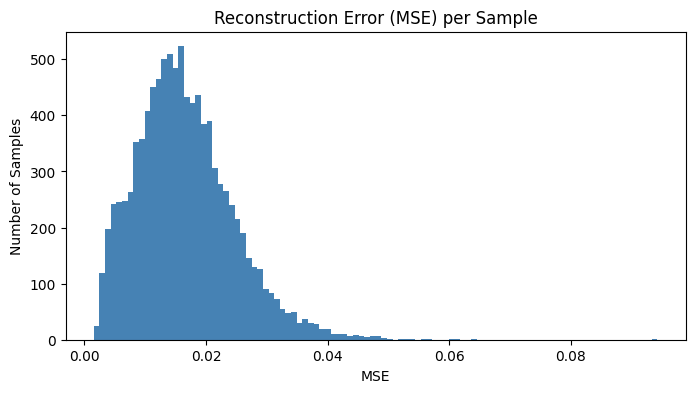

In [19]:
plot_reconstruction_error(autoencoder, x_test)

# Autoencoder

### Dataset

In [20]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32")/255.
x_test = x_test.astype("float32")/255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

### Develop Model

In [21]:
def build_encoder(input_shape): # encoder
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, kernel_size=3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)

    x = layers.Conv2D(64, kernel_size=3, activation="relu", padding="same")(x)
    encoded = layers.MaxPooling2D(pool_size=2, padding="same")(x)

    encoder_model = models.Model(inputs, encoded, name="Encoder")
    return encoder_model

def build_decoder(encoded_shape): # decoder
    encoded_inputs = layers.Input(shape=encoded_shape)

    x = layers.Conv2D(64, kernel_size=3, activation="relu", padding="same")(encoded_inputs)
    x = layers.UpSampling2D(size=2)(x)

    x = layers.Conv2D(32, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.UpSampling2D(size=2)(x)

    decoded = layers.Conv2D(1, kernel_size=3, activation="sigmoid", padding="same")(x)

    decoder_model = models.Model(encoded_inputs, decoded, name="Decoder")
    return decoder_model

In [22]:
input_shape = x_train[0].shape
encoder = build_encoder(input_shape)
decoder = build_decoder(encoder.output_shape[1:])
autoencoder = models.Model(encoder.input, decoder(encoder.output), name="Autoencoder")
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [23]:
encoder.summary()

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,816 (73.50 KB)

 Trainable params: 18,816 (73.50 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
decoder.summary()

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,681 (217.50 KB)

 Trainable params: 55,681 (217.50 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
autoencoder.summary()

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder (Functional)                 │ (None, 28, 28, 1)           │          55,681 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = autoencoder.fit(x_train, x_train, epochs=10, batch_size=64, validation_split=0.1)

Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.1461 - val_loss: 0.0713
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0699 - val_loss: 0.0688
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0677 - val_loss: 0.0674
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0666 - val_loss: 0.0664
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0657 - val_loss: 0.0658
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0654 - val_loss: 0.0655
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0648 - val_loss: 0.0649
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0643 - val_loss: 0.0646
Epoch 9/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0640 - val_loss: 0.0646
Epoch 10/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0640 - val_loss: 0.0644


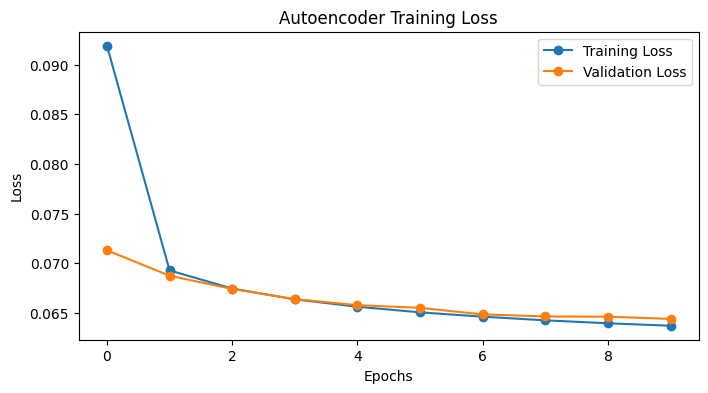

In [27]:
plot_loss(history)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


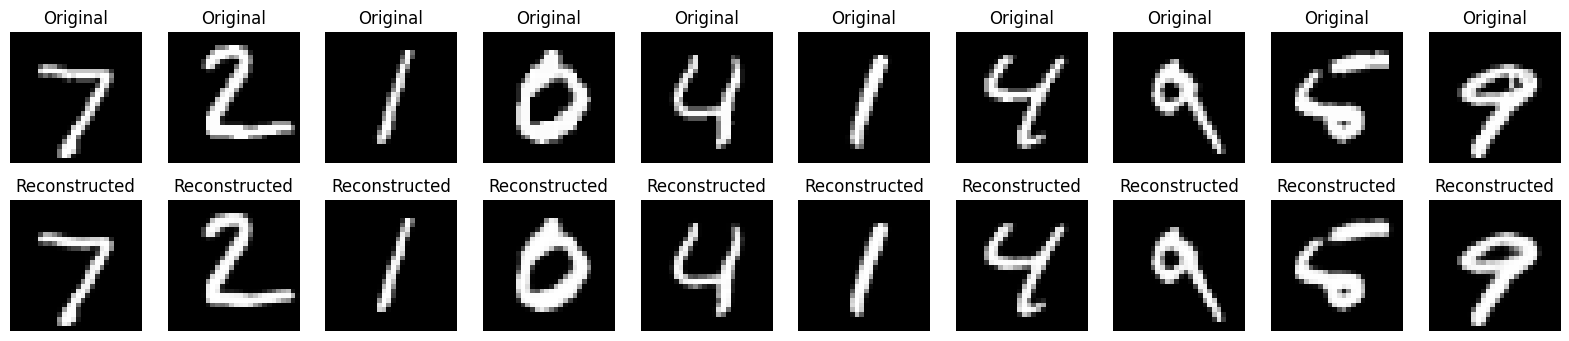

In [28]:
plot_reconstructions(autoencoder, x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


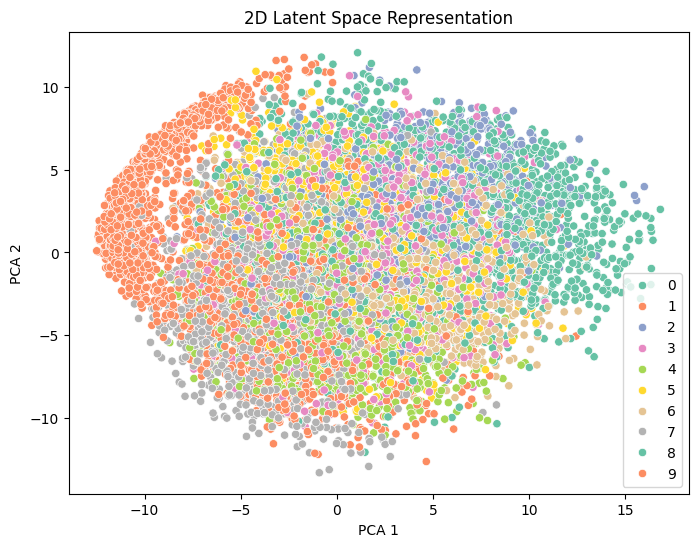

In [29]:
latent_representations = encoder.predict(x_test)
plot_latent_space(encoder, x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


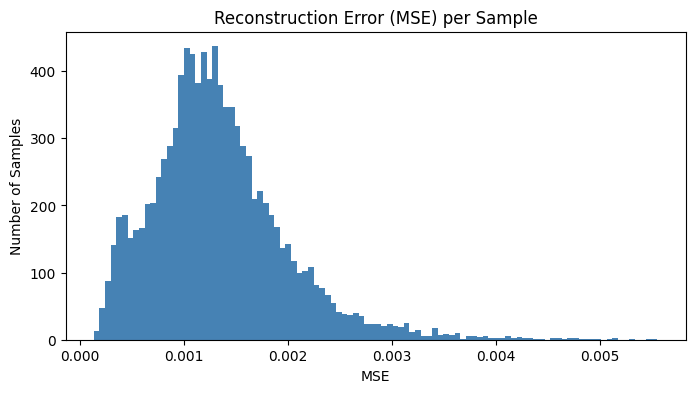

In [30]:
plot_reconstruction_error(autoencoder, x_test)